In [291]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

In [292]:
plt.rc('font', family='applegothic')
plt.rcParams['axes.unicode_minus'] = False #마이너스 기호가 깨지지 않기 위해 하는 코드

In [293]:
# 데이터 불러오기
df1 = pd.read_excel('사용데이터/기상_역_동매핑.xlsx')
df2 = pd.read_excel('사용데이터/대기_역-지점.xlsx')
df_raw_2024 = pd.read_excel('사용데이터/2024_대기.xlsx', header=None)
df_raw_2023 = pd.read_excel('사용데이터/2023_대기.xlsx', header=None)
df_raw = pd.read_excel('사용데이터/미세먼지데이터.xlsx', header=None)
df2025 = pd.read_csv('사용데이터/대구교통공사_역별일별시간별승하차인원현황_20250430.csv', encoding = 'euc-kr')
df2024 = pd.read_csv('사용데이터/역별일별시간별승하차인원현황_20241231.csv', encoding = 'euc-kr')
df2023 = pd.read_csv('사용데이터/역별일별시간별승하차인원현황_20231231.csv', encoding = 'euc-kr')
weather = pd.read_csv('사용데이터/weather_all.csv', encoding = 'cp949')


# 전처리


## df1(지하철역명 - 기상관측위치) 전처리

In [294]:
df1.head()

,호선,역명,출구번호,latitude,longitude,nearest_weather_station,distance_km_to_weather
0,1,설화명곡,1,35.79898,128.4888,옥포,3.917173
1,1,설화명곡,2,35.79848,128.4888,옥포,3.923587
2,1,설화명곡,3,35.79833,128.4890,옥포,3.943556
3,1,설화명곡,4,35.79831,128.4896,옥포,3.997521
4,1,설화명곡,5,35.79868,128.4901,옥포,4.037393


In [295]:
#df1에서 역명 하나만 남기기('출구번호' 없앰)

df1 = df1.groupby(['호선', '역명'], sort=False)[['nearest_weather_station','latitude','longitude']].first().reset_index()

df1.head()

,호선,역명,nearest_weather_station,latitude,longitude
0,1,설화명곡,옥포,35.79898,128.4888
1,1,화원,옥포,35.80432,128.5000
2,1,대곡,옥포,35.80951,128.5122
3,1,진천,대구서구,35.81388,128.5223
4,1,월배,대구서구,35.81612,128.5299


## 역별일별교통량 데이터 전처리

In [ ]:
import pandas as pd

def add_date_and_weekday(df: pd.DataFrame, year: int) -> pd.DataFrame:
    """
    데이터프레임에 전처리(역명 변경/삭제)를 수행하고,
    '년', '날짜', '요일' 열을 추가한 뒤,
    '날짜'(월,일), '역명', '승하차'가 중복된 경우 마지막 정보를 남기고 덮어씌웁니다.

    Args:
        df (pd.DataFrame): '월', '일', '역명', '승하차' 열을 포함하는 데이터프레임.
        year (int): 적용할 연도 (예: 2023, 2024).

    Returns:
        pd.DataFrame: 전처리가 완료되고 중복 제거된 새로운 데이터프레임.
    """
    # 1) 복사
    df_copy = df.copy()

    # 2) 역명 전처리
    stations_to_delete = ['대구한의대병원', '부호', '하양']
    df_copy = df_copy[~df_copy['역명'].isin(stations_to_delete)]

    station_rename_map = {
        '수성알파시티': '대공원',
        '어린이세상': '어린이회관'
    }
    df_copy['역명'] = df_copy['역명'].replace(station_rename_map)

    # 3) 년/날짜/요일 추가
    df_copy['년'] = year
    df_copy['날짜'] = pd.to_datetime({
        'year': year,
        'month': df_copy['월'],
        'day': df_copy['일']
    })
    weekday_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
    df_copy['요일'] = df_copy['날짜'].dt.dayofweek.map(weekday_map)

    # 4) 중복 제거: 마지막 정보만 남김
    df_copy = df_copy.drop_duplicates(
        subset=['월', '일','역명', '승하차'],
        keep='last'
    ).reset_index(drop=True)

    return df_copy

# 적용 예시:
df2025 = add_date_and_weekday(df2025, 2025)
df2024 = add_date_and_weekday(df2024, 2024)
df2023 = add_date_and_weekday(df2023, 2023)

In [297]:
print(df2025.shape,df2024.shape,df2023.shape)

#(22560, 25) (66798, 25) (72072, 25)
#(21840, 28) (66612, 28) (72072, 28)

(21840, 28) (66612, 28) (66430, 28)


## df_raw(지하철명- 미세먼지관측) 전처리

In [298]:
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
0,일자,수창동,NaN,NaN,NaN,지산동,NaN,NaN,NaN,서호동,NaN,NaN,NaN,대명동,NaN,NaN,NaN,신암동,NaN,NaN,NaN,태전동,NaN,NaN,NaN,만촌동,NaN,NaN,NaN,호림동,NaN,NaN,NaN,시지동,NaN,NaN,NaN,진천동,NaN,NaN,NaN,다사읍,NaN,NaN,NaN,화원읍,NaN,NaN,NaN,내당동,NaN,NaN,NaN,침산동,NaN,NaN,NaN,남산1동,NaN,NaN,NaN,평리동,NaN,NaN,NaN,이곡동,NaN,NaN,NaN,연호동,NaN,NaN,NaN,용계동,NaN,NaN,NaN
1,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN,PM2.5,NaN,PM10,NaN
2,2025-01-01 09:00:52,좋음,14,좋음,29,좋음,14,좋음,29,보통,17,보통,33,좋음,15,보통,40,좋음,13.0,좋음,30.0,보통,17.0,보통,33.0,보통,18.0,보통,35,좋음,14,좋음,30,좋음,13,좋음,27,보통,16,보통,35,보통,16.0,좋음,28.0,좋음,13.0,좋음,26.0,보통,18.0,보통,35.0,보통,16.0,좋음,30.0,보통,17.0,보통,33.0,좋음,14.0,보통,33.0,보통,18,보통,33,좋음,14.0,보통,36.0,점검중,-,점검중,-
3,2025-01-02 09:00:52,보통,19,보통,37,보통,21,보통,39,보통,19,보통,39,보통,19,보통,48,보통,18.0,보통,35.0,보통,22.0,보통,40.0,보통,21.0,보통,41,보통,20,보통,35,보통,22,보통,37,보통,23,보통,45,보통,18.0,보통,34.0,보통,25.0,보통,43.0,보통,22.0,보통,42.0,보통,22.0,보통,37.0,보통,21.0,보통,40.0,보통,22.0,보통,42.0,보통,25,보통,42,보통,21.0,보통,47.0,점검중,-,점검중,-
4,2025-01-03 09:00:52,좋음,10,좋음,19,좋음,14,좋음,23,좋음,13,좋음,22,좋음,11,좋음,27,좋음,10.0,좋음,21.0,좋음,14.0,좋음,23.0,좋음,14.0,좋음,26,좋음,12,좋음,21,좋음,14,좋음,20,좋음,12,좋음,24,좋음,11.0,좋음,18.0,좋음,11.0,좋음,18.0,좋음,11.0,좋음,21.0,좋음,13.0,좋음,20.0,좋음,12.0,좋음,21.0,좋음,12.0,좋음,26.0,좋음,14,좋음,24,좋음,13.0,좋음,28.0,점검중,-,점검중,-


In [299]:

def restructure_pollution_data(df_raw):
  """
  복잡한 구조의 원본 대기오염 데이터프레임을 분석하기 쉬운 형태로 재구조화합니다.
  '일자' 컬럼은 연-월-일 형식으로 정규화됩니다.

  이 함수는 다음 과정을 수행합니다:
  1. 2중 헤더(동, 항목)를 단일 컬럼명으로 결합합니다.
  2. 데이터를 긴 형식(long format)으로 변환(melt)합니다.
  3. 등급과 수치 데이터를 별도 컬럼으로 분리(pivot)합니다.
  4. 최종적으로 정리된 데이터프레임을 반환합니다.

  Args:
    df_raw (pd.DataFrame): 재구조화가 필요한 원본 데이터프레임.
                           첫 행은 '동', 둘째 행은 '항목' 정보를 포함해야 합니다.

  Returns:
    pd.DataFrame: '일자', '동', '항목별 등급/수치' 컬럼을 갖는 정리된 데이터프레임.
  """
  # 0. 원본 데이터프레임 복사
  df = df_raw.copy()

  # 1. 헤더 정보 추출 및 단일 레벨 컬럼명 생성
  dong_headers = df.iloc[0, 1:].ffill()
  item_headers = df.iloc[1, 1:]
  
  combined_headers = [f"{dong}_{item}" for dong, item in zip(dong_headers, item_headers.ffill())]
  
  df.columns = ['일자'] + combined_headers
  
  # 2. 실제 데이터부 추출 및 '일자' 변환
  df_data = df.iloc[2:].reset_index(drop=True)
  df_data['일자'] = pd.to_datetime(df_data['일자'], errors='coerce')
  
  # 3. 긴 형태로 melt
  df_melted = df_data.melt(
      id_vars='일자',
      var_name='동_항목',
      value_name='값'
  )
  
  # 4. '동'과 '항목' 분리
  df_melted[['동', '항목']] = df_melted['동_항목'].str.split('_', expand=True)
  
  # 5. 등급(0) / 수치(1) 구분 인덱스 부여
  df_melted['type'] = df_melted.groupby(
      ['일자', '동', '항목']
  ).cumcount().map({0: '등급', 1: '수치'})
  
  # 6. pivot_table로 wide 형태 생성
  df_wide = df_melted.pivot_table(
      index=['일자', '동'],
      columns=['항목', 'type'],
      values='값',
      aggfunc='first'
  )
  
  # 7. MultiIndex 컬럼 평탄화
  df_wide.columns = [
      f"{pollutant}{suffix}"
      for pollutant, suffix in df_wide.columns
  ]
  
  # 8. 인덱스 리셋
  df_wide = df_wide.reset_index()
  
  # ★★★★★★★★★★★★ 여기 추가된 부분 ★★★★★★★★★★★★
  # '일자' 컬럼의 시간을 00:00:00으로 정규화하여 날짜만 표시되도록 합니다.
  df_wide['일자'] = df_wide['일자'].dt.normalize()
  # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

  # 9. 필요 시 수치 컬럼 숫자형 변환
  for col in df_wide.columns:
      if '수치' in col:
          df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce')

  return df_wide

# --- 함수 사용 ---
# 이제 이 함수를 사용하여 데이터프레임을 만들면
# df_wide_2025, df_wide_2024, df_wide_2023 등의 '일자' 컬럼은
# 모두 연-월-일 형식으로 표시됩니다.

# 예시:
# df_wide_2025 = restructure_pollution_data(df_raw)
# print(df_wide_2025)
df_wide_2025 = restructure_pollution_data(df_raw)
df_wide_2024 = restructure_pollution_data(df_raw_2024)
df_wide_2023 = restructure_pollution_data(df_raw_2023)

In [300]:
#학습할 df 만들기
combined_df = pd.concat([df2023, df2024], ignore_index=True)
combined_df = combined_df.drop_duplicates()
combined_df_dirt = pd.concat([df_wide_2023, df_wide_2024], ignore_index=True)

## df2:역-지점 전처리

In [301]:
combined_df

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일
0,1,1,1150,설화명곡,승차,26,39,63,105,132,154,172,270,210,233,219,211,216,119,122,58,48,26,3,2426,2023,2023-01-01,일
1,1,1,1150,설화명곡,하차,0,65,49,55,90,84,122,150,113,147,193,184,218,175,165,140,168,101,57,2276,2023,2023-01-01,일
2,1,1,1160,화원,승차,19,44,40,115,129,164,208,294,280,310,302,254,230,136,80,60,59,34,2,2760,2023,2023-01-01,일
3,1,1,1160,화원,하차,4,57,44,76,116,166,232,173,255,285,276,209,198,180,139,88,98,106,70,2772,2023,2023-01-01,일
4,1,1,1170,대곡,승차,26,48,66,117,149,164,170,223,228,223,187,182,160,127,89,61,60,38,9,2327,2023,2023-01-01,일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133037,12,31,3390,지산,하차,3,18,28,151,98,87,79,118,143,123,212,184,230,247,116,69,78,55,37,2076,2024,2024-12-31,화
133038,12,31,3400,범물,승차,96,97,289,381,252,248,314,294,301,322,332,332,266,265,119,101,96,79,13,4197,2024,2024-12-31,화
133039,12,31,3400,범물,하차,47,30,92,228,162,200,220,229,265,337,311,430,334,397,194,146,124,80,55,3881,2024,2024-12-31,화
133040,12,31,3410,용지,승차,27,46,138,240,156,222,223,212,199,221,177,173,135,124,49,76,60,78,102,2658,2024,2024-12-31,화


In [302]:
df2.head()

,역명,지점
0,설화명곡,화원읍
1,화원역,화원읍
2,대곡역,진천동
3,진천역,진천동
4,월배역,진천동


In [303]:
# 끝에 단 하나의 '역'이 있으면 제거해서 통일화
df2['역명'] = df2['역명'].str.replace(r'역$', '', regex=True)

df2

,역명,지점
0,설화명곡,화원읍
1,화원,화원읍
2,대곡,진천동
3,진천,진천동
4,월배,진천동
...,...,...
89,칠곡운암,태전동
90,동천,태전동
91,팔거,태전동
92,학정,태전동


## weather 데이터 전처리

In [304]:
weather

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),평균 풍속(m/s),최대 순간 풍속 풍향(deg)
0,828,달성,2023-01-01,0.1,-7.6,9.1,0.0,8.1,1.4,19.7
1,828,달성,2023-01-02,0.8,-2.2,5.2,0.0,8.6,2.6,8.3
2,828,달성,2023-01-03,0.0,-4.5,6.0,0.0,8.6,2.3,0.0
3,828,달성,2023-01-04,0.2,-5.5,7.6,0.0,6.6,1.9,14.0
4,828,달성,2023-01-05,-0.3,-6.9,7.6,0.0,4.1,1.0,340.6
...,...,...,...,...,...,...,...,...,...,...
5287,992,하빈,2025-05-27,20.0,12.3,28.7,0.0,5.8,1.2,292.1
5288,992,하빈,2025-05-28,19.9,12.8,28.8,1.5,5.9,1.2,157.3
5289,992,하빈,2025-05-29,19.4,12.6,27.8,0.0,6.9,1.5,319.2
5290,992,하빈,2025-05-30,18.6,12.0,26.4,0.0,9.7,1.9,295.1


In [305]:
weather['일시'] = pd.to_datetime(weather['일시'])

In [306]:
weather

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),평균 풍속(m/s),최대 순간 풍속 풍향(deg)
0,828,달성,2023-01-01,0.1,-7.6,9.1,0.0,8.1,1.4,19.7
1,828,달성,2023-01-02,0.8,-2.2,5.2,0.0,8.6,2.6,8.3
2,828,달성,2023-01-03,0.0,-4.5,6.0,0.0,8.6,2.3,0.0
3,828,달성,2023-01-04,0.2,-5.5,7.6,0.0,6.6,1.9,14.0
4,828,달성,2023-01-05,-0.3,-6.9,7.6,0.0,4.1,1.0,340.6
...,...,...,...,...,...,...,...,...,...,...
5287,992,하빈,2025-05-27,20.0,12.3,28.7,0.0,5.8,1.2,292.1
5288,992,하빈,2025-05-28,19.9,12.8,28.8,1.5,5.9,1.2,157.3
5289,992,하빈,2025-05-29,19.4,12.6,27.8,0.0,6.9,1.5,319.2
5290,992,하빈,2025-05-30,18.6,12.0,26.4,0.0,9.7,1.9,295.1


## 데이터 결합

역별일별 데이터에서 역에 가장 가까운 대기먼지 측정 지점 JOIN

In [307]:
#2025
# 1) right_on df2 쪽 키인 '역'을, left_on Df 쪽 '역명'을 지정
df2025 = pd.merge(
    df2025,
    df2,
    left_on  = '역명',
    right_on = '역명',
    how      = 'left'
)

df2025.columns


Index(['월', '일', '역번호', '역명', '승하차', '05시-06시', '06시-07시', '07시-08시', '08시-09시', '09시-10시', '10시-11시', '11시-12시', '12시-13시', '13시-14시', '14시-15시', '15시-16시', '16시-17시', '17시-18시', '18시-19시', '19시-20시', '20시-21시', '21시-22시', '22시-23시', '23시-24시', '일계', '년', '날짜', '요일', '지점'], dtype='object')

In [308]:
#학습할 df들
combined_df = pd.merge(
    combined_df,
    df2,
    left_on  = '역명',
    right_on = '역명',
    how      = 'left'
)



In [309]:
print(df2025[df2025.isnull().any(axis=1)])
print(combined_df[combined_df.isnull().any(axis=1)])

Empty DataFrame
Columns: [월, 일, 역번호, 역명, 승하차, 05시-06시, 06시-07시, 07시-08시, 08시-09시, 09시-10시, 10시-11시, 11시-12시, 12시-13시, 13시-14시, 14시-15시, 15시-16시, 16시-17시, 17시-18시, 18시-19시, 19시-20시, 20시-21시, 21시-22시, 22시-23시, 23시-24시, 일계, 년, 날짜, 요일, 지점]
Index: []
Empty DataFrame
Columns: [월, 일, 역번호, 역명, 승하차, 05시-06시, 06시-07시, 07시-08시, 08시-09시, 09시-10시, 10시-11시, 11시-12시, 12시-13시, 13시-14시, 14시-15시, 15시-16시, 16시-17시, 17시-18시, 18시-19시, 19시-20시, 20시-21시, 21시-22시, 22시-23시, 23시-24시, 일계, 년, 날짜, 요일, 지점]
Index: []


지점에 맞는 대기먼지 데이터 JOIN

In [310]:
#2025년
df2025 = pd.merge(
    df2025,
    df_wide_2025,
    left_on  = ['날짜', '지점'],
    right_on = ['일자', '동'],
    how       = 'left'
)

In [311]:
#combined_df 합치기
combined_df = pd.merge(
    combined_df,
    combined_df_dirt,
    left_on  = ['날짜', '지점'],
    right_on = ['일자', '동'],
    how       = 'left'
)

In [312]:
df2025[df2025.isna().any(axis=1)]

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치
46,1,1,1380,동촌,승차,16,22,185,293,104,86,113,109,107,113,103,106,110,67,41,48,30,24,15,1692,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN
47,1,1,1380,동촌,하차,23,174,265,53,55,58,67,71,103,106,102,92,92,81,85,54,51,32,25,1589,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN
48,1,1,1390,해안,승차,26,33,47,55,85,96,108,132,134,100,119,73,83,53,50,34,33,17,3,1281,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN
49,1,1,1390,해안,하차,11,21,23,35,38,51,60,106,73,91,103,135,121,95,75,62,63,46,17,1226,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN
50,1,1,1400,방촌,승차,31,54,68,78,124,129,141,160,157,145,101,123,112,108,68,50,31,27,11,1718,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20825,4,25,2220,이곡,하차,12,78,240,397,116,122,145,135,151,194,222,311,337,411,265,139,187,172,195,3829,2025,2025-04-25,금,이곡동,2025-04-25,이곡동,점검중,NaN,점검중,NaN
20826,4,25,2230,용산,승차,114,176,683,823,461,397,416,395,383,408,468,807,757,735,379,269,199,114,47,8031,2025,2025-04-25,금,이곡동,2025-04-25,이곡동,점검중,NaN,점검중,NaN
20827,4,25,2230,용산,하차,26,174,359,693,310,235,317,365,489,399,531,643,732,834,516,354,310,402,284,7973,2025,2025-04-25,금,이곡동,2025-04-25,이곡동,점검중,NaN,점검중,NaN
20828,4,25,2240,죽전,승차,59,182,705,866,407,396,377,395,383,372,428,546,736,731,406,298,260,196,125,7868,2025,2025-04-25,금,이곡동,2025-04-25,이곡동,점검중,NaN,점검중,NaN


In [313]:
# isna()로 전체 DataFrame의 NaN 위치를 찾고,
# .any(axis=1)으로 각 "행"에 NaN이 하나라도 있는지 확인합니다.
condition0 = combined_df['PM10등급'] != '점검중'
condition1 = combined_df['PM2.5등급'] != '점검중'
condition2 = combined_df.isna().any(axis=1)

# 두 조건을 & 로 결합합니다.
filtered_df = combined_df[condition0&condition1 & condition2]

filtered_df

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치


점검중 -> 결측값 존재

지하철역에 가장 가까운 기상관측지점 JOIN

In [314]:
df2025 = pd.merge(df2025, df1,
              how='left',
              left_on=['역명'],
              right_on=['역명'],
              )


In [315]:
df2025[df2025.isna().any(axis=1)]

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치,호선,nearest_weather_station,latitude,longitude
46,1,1,1380,동촌,승차,16,22,185,293,104,86,113,109,107,113,103,106,110,67,41,48,30,24,15,1692,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88634,128.6505
47,1,1,1380,동촌,하차,23,174,265,53,55,58,67,71,103,106,102,92,92,81,85,54,51,32,25,1589,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88634,128.6505
48,1,1,1390,해안,승차,26,33,47,55,85,96,108,132,134,100,119,73,83,53,50,34,33,17,3,1281,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88377,128.6591
49,1,1,1390,해안,하차,11,21,23,35,38,51,60,106,73,91,103,135,121,95,75,62,63,46,17,1226,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88377,128.6591
50,1,1,1400,방촌,승차,31,54,68,78,124,129,141,160,157,145,101,123,112,108,68,50,31,27,11,1718,2025,2025-01-01,수,용계동,2025-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.87992,128.6698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20825,4,25,2220,이곡,하차,12,78,240,397,116,122,145,135,151,194,222,311,337,411,265,139,187,172,195,3829,2025,2025-04-25,금,이곡동,2025-04-25,이곡동,점검중,NaN,점검중,NaN,2,대구서구,35.85088,128.5151
20826,4,25,2230,용산,승차,114,176,683,823,461,397,416,395,383,408,468,807,757,735,379,269,199,114,47,8031,2025,2025-04-25,금,이곡동,2025-04-25,이곡동,점검중,NaN,점검중,NaN,2,대구서구,35.84918,128.5281
20827,4,25,2230,용산,하차,26,174,359,693,310,235,317,365,489,399,531,643,732,834,516,354,310,402,284,7973,2025,2025-04-25,금,이곡동,2025-04-25,이곡동,점검중,NaN,점검중,NaN,2,대구서구,35.84918,128.5281
20828,4,25,2240,죽전,승차,59,182,705,866,407,396,377,395,383,372,428,546,736,731,406,298,260,196,125,7868,2025,2025-04-25,금,이곡동,2025-04-25,이곡동,점검중,NaN,점검중,NaN,2,대구서구,35.85056,128.5369


In [316]:
#combined

combined_df = pd.merge(combined_df, df1,
              how='left',
              left_on=['역명'],
              right_on=['역명'],
              )

In [317]:
combined_df[combined_df.isna().any(axis=1)]

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치,호선,nearest_weather_station,latitude,longitude
46,1,1,1380,동촌,승차,12,22,97,338,77,99,91,113,115,109,131,121,91,60,44,27,30,24,12,1613,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88634,128.6505
47,1,1,1380,동촌,하차,20,181,199,62,38,95,56,86,93,134,102,101,85,66,66,70,46,47,30,1577,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88634,128.6505
48,1,1,1390,해안,승차,21,38,37,78,87,95,80,76,103,120,109,95,123,62,47,25,12,21,7,1236,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88377,128.6591
49,1,1,1390,해안,하차,12,22,33,44,40,63,52,63,83,111,100,90,121,108,51,62,51,62,33,1201,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88377,128.6591
50,1,1,1400,방촌,승차,30,55,65,90,118,151,116,162,178,164,137,128,109,73,72,35,40,24,13,1760,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.87992,128.6698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132917,12,31,1430,신기,하차,4,25,103,290,133,221,222,205,197,228,291,317,314,319,206,193,138,106,78,3590,2024,2024-12-31,화,용계동,2024-12-31,용계동,점검중,NaN,점검중,NaN,1,신암,35.86684,128.7022
132920,12,31,1450,각산,승차,911,1248,1520,1430,1371,1595,1492,1498,1456,1449,652,326,306,345,180,154,164,109,44,16250,2024,2024-12-31,화,용계동,2024-12-31,용계동,점검중,NaN,점검중,NaN,1,신암,35.86812,128.7242
132921,12,31,1450,각산,하차,3,41,175,333,191,143,185,234,256,235,432,369,414,557,277,201,159,137,96,4438,2024,2024-12-31,화,용계동,2024-12-31,용계동,점검중,NaN,점검중,NaN,1,신암,35.86812,128.7242
132922,12,31,1460,안심,승차,107,109,310,506,340,255,272,256,347,250,358,707,445,420,122,129,79,73,12,5097,2024,2024-12-31,화,용계동,2024-12-31,용계동,점검중,NaN,점검중,NaN,1,신암,35.87136,128.7334


기상관측 지점에 따른 기상데이터 정보 결합

In [318]:
#2025년
df2025 = pd.merge(df2025, weather,
              left_on = ['nearest_weather_station','날짜'],
              right_on= ['지점명','일시'],
              how = 'left')

df2025

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점_x,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치,호선,nearest_weather_station,latitude,longitude,지점_y,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),평균 풍속(m/s),최대 순간 풍속 풍향(deg)
0,1,1,1150,설화명곡,승차,50,40,78,104,144,165,192,218,232,230,188,168,170,136,79,76,38,23,8,2339,2025,2025-01-01,수,화원읍,2025-01-01,화원읍,좋음,26.0,좋음,13.0,1,옥포,35.79898,128.4888,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
1,1,1,1150,설화명곡,하차,2,99,48,74,69,78,119,119,115,134,170,160,211,193,131,133,112,88,85,2140,2025,2025-01-01,수,화원읍,2025-01-01,화원읍,좋음,26.0,좋음,13.0,1,옥포,35.79898,128.4888,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
2,1,1,1160,화원,승차,26,42,47,103,152,220,261,262,325,288,308,271,195,105,89,38,42,30,7,2811,2025,2025-01-01,수,화원읍,2025-01-01,화원읍,좋음,26.0,좋음,13.0,1,옥포,35.80432,128.5000,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
3,1,1,1160,화원,하차,5,71,46,83,141,177,243,242,253,240,292,251,155,154,121,120,85,77,74,2830,2025,2025-01-01,수,화원읍,2025-01-01,화원읍,좋음,26.0,좋음,13.0,1,옥포,35.80432,128.5000,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
4,1,1,1170,대곡,승차,23,48,70,119,162,179,233,253,231,205,179,182,161,132,83,81,41,36,8,2426,2025,2025-01-01,수,진천동,2025-01-01,진천동,보통,35.0,보통,16.0,1,옥포,35.80951,128.5122,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21835,4,30,3390,지산,하차,3,23,66,170,120,118,128,150,168,160,136,199,264,313,159,130,95,84,53,2539,2025,2025-04-30,수,지산동,2025-04-30,지산동,보통,41.0,보통,21.0,3,신암,35.82541,128.6316,860,신암,2025-04-30,19.9,11.6,30.0,0.0,8.1,1.5,167.1
21836,4,30,3400,범물,승차,71,126,351,432,324,303,303,326,265,255,248,255,255,266,149,124,99,71,19,4242,2025,2025-04-30,수,지산동,2025-04-30,지산동,보통,41.0,보통,21.0,3,신암,35.82110,128.6400,860,신암,2025-04-30,19.9,11.6,30.0,0.0,8.1,1.5,167.1
21837,4,30,3400,범물,하차,6,36,87,252,210,222,220,230,230,349,347,372,419,454,259,180,164,121,104,4262,2025,2025-04-30,수,지산동,2025-04-30,지산동,보통,41.0,보통,21.0,3,신암,35.82110,128.6400,860,신암,2025-04-30,19.9,11.6,30.0,0.0,8.1,1.5,167.1
21838,4,30,3410,용지,승차,41,62,199,223,184,155,160,174,182,178,132,154,169,140,93,72,23,28,10,2379,2025,2025-04-30,수,지산동,2025-04-30,지산동,보통,41.0,보통,21.0,3,신암,35.81847,128.6465,860,신암,2025-04-30,19.9,11.6,30.0,0.0,8.1,1.5,167.1


In [319]:
#합치기
combined_df = pd.merge(combined_df, weather,
              left_on = ['nearest_weather_station','날짜'],
              right_on= ['지점명','일시'],
              how = 'left')

combined_df

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점_x,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치,호선,nearest_weather_station,latitude,longitude,지점_y,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),평균 풍속(m/s),최대 순간 풍속 풍향(deg)
0,1,1,1150,설화명곡,승차,26,39,63,105,132,154,172,270,210,233,219,211,216,119,122,58,48,26,3,2426,2023,2023-01-01,일,화원읍,2023-01-01,화원읍,보통,40.0,보통,30.0,1,옥포,35.79898,128.4888,991,옥포,2023-01-01,-0.9,-8.4,7.8,0.0,8.8,1.8,335.1
1,1,1,1150,설화명곡,하차,0,65,49,55,90,84,122,150,113,147,193,184,218,175,165,140,168,101,57,2276,2023,2023-01-01,일,화원읍,2023-01-01,화원읍,보통,40.0,보통,30.0,1,옥포,35.79898,128.4888,991,옥포,2023-01-01,-0.9,-8.4,7.8,0.0,8.8,1.8,335.1
2,1,1,1160,화원,승차,19,44,40,115,129,164,208,294,280,310,302,254,230,136,80,60,59,34,2,2760,2023,2023-01-01,일,화원읍,2023-01-01,화원읍,보통,40.0,보통,30.0,1,옥포,35.80432,128.5000,991,옥포,2023-01-01,-0.9,-8.4,7.8,0.0,8.8,1.8,335.1
3,1,1,1160,화원,하차,4,57,44,76,116,166,232,173,255,285,276,209,198,180,139,88,98,106,70,2772,2023,2023-01-01,일,화원읍,2023-01-01,화원읍,보통,40.0,보통,30.0,1,옥포,35.80432,128.5000,991,옥포,2023-01-01,-0.9,-8.4,7.8,0.0,8.8,1.8,335.1
4,1,1,1170,대곡,승차,26,48,66,117,149,164,170,223,228,223,187,182,160,127,89,61,60,38,9,2327,2023,2023-01-01,일,진천동,2023-01-01,진천동,보통,45.0,보통,32.0,1,옥포,35.80951,128.5122,991,옥포,2023-01-01,-0.9,-8.4,7.8,0.0,8.8,1.8,335.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133037,12,31,3390,지산,하차,3,18,28,151,98,87,79,118,143,123,212,184,230,247,116,69,78,55,37,2076,2024,2024-12-31,화,지산동,2024-12-31,지산동,보통,34.0,보통,16.0,3,신암,35.82541,128.6316,860,신암,2024-12-31,4.2,0.7,7.2,0.0,10.8,1.4,293.0
133038,12,31,3400,범물,승차,96,97,289,381,252,248,314,294,301,322,332,332,266,265,119,101,96,79,13,4197,2024,2024-12-31,화,지산동,2024-12-31,지산동,보통,34.0,보통,16.0,3,신암,35.82110,128.6400,860,신암,2024-12-31,4.2,0.7,7.2,0.0,10.8,1.4,293.0
133039,12,31,3400,범물,하차,47,30,92,228,162,200,220,229,265,337,311,430,334,397,194,146,124,80,55,3881,2024,2024-12-31,화,지산동,2024-12-31,지산동,보통,34.0,보통,16.0,3,신암,35.82110,128.6400,860,신암,2024-12-31,4.2,0.7,7.2,0.0,10.8,1.4,293.0
133040,12,31,3410,용지,승차,27,46,138,240,156,222,223,212,199,221,177,173,135,124,49,76,60,78,102,2658,2024,2024-12-31,화,지산동,2024-12-31,지산동,보통,34.0,보통,16.0,3,신암,35.81847,128.6465,860,신암,2024-12-31,4.2,0.7,7.2,0.0,10.8,1.4,293.0


In [320]:
combined_df[combined_df.isna().any(axis =1)]

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점_x,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치,호선,nearest_weather_station,latitude,longitude,지점_y,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),평균 풍속(m/s),최대 순간 풍속 풍향(deg)
46,1,1,1380,동촌,승차,12,22,97,338,77,99,91,113,115,109,131,121,91,60,44,27,30,24,12,1613,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88634,128.6505,860,신암,2023-01-01,2.3,-2.3,7.1,0.0,9.5,1.1,310.8
47,1,1,1380,동촌,하차,20,181,199,62,38,95,56,86,93,134,102,101,85,66,66,70,46,47,30,1577,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88634,128.6505,860,신암,2023-01-01,2.3,-2.3,7.1,0.0,9.5,1.1,310.8
48,1,1,1390,해안,승차,21,38,37,78,87,95,80,76,103,120,109,95,123,62,47,25,12,21,7,1236,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88377,128.6591,860,신암,2023-01-01,2.3,-2.3,7.1,0.0,9.5,1.1,310.8
49,1,1,1390,해안,하차,12,22,33,44,40,63,52,63,83,111,100,90,121,108,51,62,51,62,33,1201,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.88377,128.6591,860,신암,2023-01-01,2.3,-2.3,7.1,0.0,9.5,1.1,310.8
50,1,1,1400,방촌,승차,30,55,65,90,118,151,116,162,178,164,137,128,109,73,72,35,40,24,13,1760,2023,2023-01-01,일,용계동,2023-01-01,용계동,점검중,NaN,점검중,NaN,1,신암,35.87992,128.6698,860,신암,2023-01-01,2.3,-2.3,7.1,0.0,9.5,1.1,310.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132917,12,31,1430,신기,하차,4,25,103,290,133,221,222,205,197,228,291,317,314,319,206,193,138,106,78,3590,2024,2024-12-31,화,용계동,2024-12-31,용계동,점검중,NaN,점검중,NaN,1,신암,35.86684,128.7022,860,신암,2024-12-31,4.2,0.7,7.2,0.0,10.8,1.4,293.0
132920,12,31,1450,각산,승차,911,1248,1520,1430,1371,1595,1492,1498,1456,1449,652,326,306,345,180,154,164,109,44,16250,2024,2024-12-31,화,용계동,2024-12-31,용계동,점검중,NaN,점검중,NaN,1,신암,35.86812,128.7242,860,신암,2024-12-31,4.2,0.7,7.2,0.0,10.8,1.4,293.0
132921,12,31,1450,각산,하차,3,41,175,333,191,143,185,234,256,235,432,369,414,557,277,201,159,137,96,4438,2024,2024-12-31,화,용계동,2024-12-31,용계동,점검중,NaN,점검중,NaN,1,신암,35.86812,128.7242,860,신암,2024-12-31,4.2,0.7,7.2,0.0,10.8,1.4,293.0
132922,12,31,1460,안심,승차,107,109,310,506,340,255,272,256,347,250,358,707,445,420,122,129,79,73,12,5097,2024,2024-12-31,화,용계동,2024-12-31,용계동,점검중,NaN,점검중,NaN,1,신암,35.87136,128.7334,860,신암,2024-12-31,4.2,0.7,7.2,0.0,10.8,1.4,293.0


In [321]:
# isna()로 전체 DataFrame의 NaN 위치를 찾고,
# .any(axis=1)으로 각 "행"에 NaN이 하나라도 있는지 확인합니다.
condition0 = combined_df['PM10등급'] != '점검중'
condition1 = combined_df['PM2.5등급'] != '점검중'
condition2 = combined_df.isna().any(axis=1)

# 두 조건을 & 로 결합합니다.
filtered_df = combined_df[condition0&condition1 & condition2]

filtered_df

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점_x,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치,호선,nearest_weather_station,latitude,longitude,지점_y,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),평균 풍속(m/s),최대 순간 풍속 풍향(deg)
6940,2,8,1270,영대병원,승차,46,84,167,272,262,311,379,392,474,465,405,471,591,455,187,133,177,101,65,5437,2023,2023-02-08,수,대명동,2023-02-08,대명동,보통,57.0,나쁨,40.0,1,신암,35.84444,128.5883,860,신암,2023-02-08,5.5,0.0,11.7,0.0,7.1,NaN,309.0
6941,2,8,1270,영대병원,하차,28,152,303,865,627,403,262,367,347,312,297,274,316,475,222,165,146,138,77,5776,2023,2023-02-08,수,대명동,2023-02-08,대명동,보통,57.0,나쁨,40.0,1,신암,35.84444,128.5883,860,신암,2023-02-08,5.5,0.0,11.7,0.0,7.1,NaN,309.0
6942,2,8,1280,교대,승차,49,105,235,385,287,253,266,276,263,240,257,269,297,383,117,81,118,46,17,3944,2023,2023-02-08,수,대명동,2023-02-08,대명동,보통,57.0,나쁨,40.0,1,신암,35.85075,128.5904,860,신암,2023-02-08,5.5,0.0,11.7,0.0,7.1,NaN,309.0
6943,2,8,1280,교대,하차,24,52,109,505,314,155,200,177,203,203,280,283,286,382,239,185,106,108,71,3882,2023,2023-02-08,수,대명동,2023-02-08,대명동,보통,57.0,나쁨,40.0,1,신암,35.85075,128.5904,860,신암,2023-02-08,5.5,0.0,11.7,0.0,7.1,NaN,309.0
6944,2,8,1290,명덕1,승차,19,44,116,163,113,196,178,184,197,283,196,256,263,326,173,135,201,151,42,3236,2023,2023-02-08,수,대명동,2023-02-08,대명동,보통,57.0,나쁨,40.0,1,신암,35.85734,128.5906,860,신암,2023-02-08,5.5,0.0,11.7,0.0,7.1,NaN,309.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92157,5,21,2160,문양,하차,0,162,339,333,180,207,300,224,198,138,150,135,144,97,64,25,42,27,28,2793,2024,2024-05-21,화,다사읍,2024-05-21,다사읍,보통,35.0,보통,18.0,2,하빈,35.86383,128.4371,992,하빈,2024-05-21,18.8,15.3,25.2,0.0,NaN,NaN,NaN
92158,5,21,2170,다사,승차,67,178,580,604,287,213,159,187,189,182,179,304,238,231,126,56,35,33,13,3861,2024,2024-05-21,화,다사읍,2024-05-21,다사읍,보통,35.0,보통,18.0,2,하빈,35.86547,128.4580,992,하빈,2024-05-21,18.8,15.3,25.2,0.0,NaN,NaN,NaN
92159,5,21,2170,다사,하차,1,47,166,243,87,115,119,151,121,134,206,343,342,546,318,197,223,209,177,3745,2024,2024-05-21,화,다사읍,2024-05-21,다사읍,보통,35.0,보통,18.0,2,하빈,35.86547,128.4580,992,하빈,2024-05-21,18.8,15.3,25.2,0.0,NaN,NaN,NaN
92160,5,21,2180,대실,승차,74,230,909,1097,638,365,361,365,362,320,314,400,538,523,271,216,141,127,57,7308,2024,2024-05-21,화,다사읍,2024-05-21,다사읍,보통,35.0,보통,18.0,2,하빈,35.85772,128.4655,992,하빈,2024-05-21,18.8,15.3,25.2,0.0,NaN,NaN,NaN


In [322]:
print(combined_df.columns)

print(combined_df.shape)

Index(['월', '일', '역번호', '역명', '승하차', '05시-06시', '06시-07시', '07시-08시', '08시-09시', '09시-10시', '10시-11시', '11시-12시', '12시-13시', '13시-14시', '14시-15시', '15시-16시', '16시-17시', '17시-18시', '18시-19시', '19시-20시', '20시-21시', '21시-22시', '22시-23시', '23시-24시', '일계', '년', '날짜', '요일', '지점_x', '일자', '동', 'PM10등급', 'PM10수치', 'PM2.5등급', 'PM2.5수치', '호선', 'nearest_weather_station', 'latitude', 'longitude', '지점_y', '지점명', '일시', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 순간 풍속(m/s)', '평균 풍속(m/s)', '최대 순간 풍속 풍향(deg)'], dtype='object')
(133042, 49)


In [323]:
#최종표 완성

final_df = df2025.copy()

train = combined_df.copy()

In [324]:
final_df.to_excel('test.xlsx')
train.to_excel('train.xlsx')

# 2025년 분석시작

In [325]:
print((final_df == 0).sum())

월                              0
일                              0
역번호                            0
역명                             0
승하차                            0
05시-06시                      695
06시-07시                        5
07시-08시                        2
08시-09시                        0
09시-10시                        0
10시-11시                        0
11시-12시                        0
12시-13시                        0
13시-14시                        0
14시-15시                        0
15시-16시                        0
16시-17시                        0
17시-18시                        0
18시-19시                        0
19시-20시                        0
20시-21시                        0
21시-22시                        1
22시-23시                       11
23시-24시                       77
일계                             0
년                              0
날짜                             0
요일                             0
지점_x                           0
일자                             0
동         

0명이탑승한 수

05시-06시               695

06시-07시                 5

07시-08시                 2

21시-22시                 1

22시-23시                11

23시-24시                77

# EDA

In [326]:
times= ['05시-06시', '06시-07시', '07시-08시', '08시-09시', '09시-10시', '10시-11시',
       '11시-12시', '12시-13시', '13시-14시', '14시-15시', '15시-16시', '16시-17시',
       '17시-18시', '18시-19시', '19시-20시', '20시-21시', '21시-22시', '22시-23시',
       '23시-24시']

In [328]:
final_df

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점_x,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치,호선,nearest_weather_station,latitude,longitude,지점_y,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),평균 풍속(m/s),최대 순간 풍속 풍향(deg)
0,1,1,1150,설화명곡,승차,50,40,78,104,144,165,192,218,232,230,188,168,170,136,79,76,38,23,8,2339,2025,2025-01-01,수,화원읍,2025-01-01,화원읍,좋음,26.0,좋음,13.0,1,옥포,35.79898,128.4888,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
1,1,1,1150,설화명곡,하차,2,99,48,74,69,78,119,119,115,134,170,160,211,193,131,133,112,88,85,2140,2025,2025-01-01,수,화원읍,2025-01-01,화원읍,좋음,26.0,좋음,13.0,1,옥포,35.79898,128.4888,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
2,1,1,1160,화원,승차,26,42,47,103,152,220,261,262,325,288,308,271,195,105,89,38,42,30,7,2811,2025,2025-01-01,수,화원읍,2025-01-01,화원읍,좋음,26.0,좋음,13.0,1,옥포,35.80432,128.5000,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
3,1,1,1160,화원,하차,5,71,46,83,141,177,243,242,253,240,292,251,155,154,121,120,85,77,74,2830,2025,2025-01-01,수,화원읍,2025-01-01,화원읍,좋음,26.0,좋음,13.0,1,옥포,35.80432,128.5000,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
4,1,1,1170,대곡,승차,23,48,70,119,162,179,233,253,231,205,179,182,161,132,83,81,41,36,8,2426,2025,2025-01-01,수,진천동,2025-01-01,진천동,보통,35.0,보통,16.0,1,옥포,35.80951,128.5122,991,옥포,2025-01-01,0.3,-7.5,10.5,0.0,5.0,1.2,247.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21835,4,30,3390,지산,하차,3,23,66,170,120,118,128,150,168,160,136,199,264,313,159,130,95,84,53,2539,2025,2025-04-30,수,지산동,2025-04-30,지산동,보통,41.0,보통,21.0,3,신암,35.82541,128.6316,860,신암,2025-04-30,19.9,11.6,30.0,0.0,8.1,1.5,167.1
21836,4,30,3400,범물,승차,71,126,351,432,324,303,303,326,265,255,248,255,255,266,149,124,99,71,19,4242,2025,2025-04-30,수,지산동,2025-04-30,지산동,보통,41.0,보통,21.0,3,신암,35.82110,128.6400,860,신암,2025-04-30,19.9,11.6,30.0,0.0,8.1,1.5,167.1
21837,4,30,3400,범물,하차,6,36,87,252,210,222,220,230,230,349,347,372,419,454,259,180,164,121,104,4262,2025,2025-04-30,수,지산동,2025-04-30,지산동,보통,41.0,보통,21.0,3,신암,35.82110,128.6400,860,신암,2025-04-30,19.9,11.6,30.0,0.0,8.1,1.5,167.1
21838,4,30,3410,용지,승차,41,62,199,223,184,155,160,174,182,178,132,154,169,140,93,72,23,28,10,2379,2025,2025-04-30,수,지산동,2025-04-30,지산동,보통,41.0,보통,21.0,3,신암,35.81847,128.6465,860,신암,2025-04-30,19.9,11.6,30.0,0.0,8.1,1.5,167.1


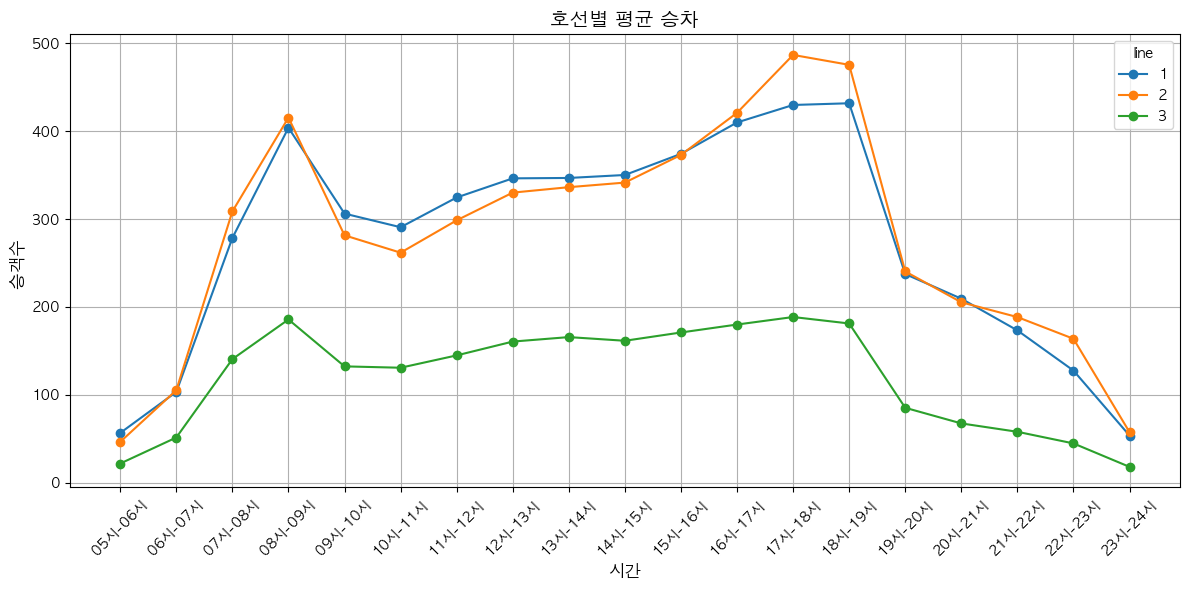

In [329]:
# 호선별 시간대별 평균 승차 인원 계산
line_time_avg = final_df[final_df['승하차'] == '승차'].groupby('호선')[times].mean().T

# 시각화
plt.figure(figsize=(12, 6))
for line in line_time_avg.columns:
    plt.plot(line_time_avg.index, line_time_avg[line], marker='o', label=line)

plt.title('호선별 평균 승차', fontsize=14) #호선별 시간대 평균 승차 인원 (혼잡도 비교)
plt.xlabel('시간', fontsize=12)#시간대
plt.ylabel('승객수 ', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='line')#호선
plt.tight_layout()
plt.show()

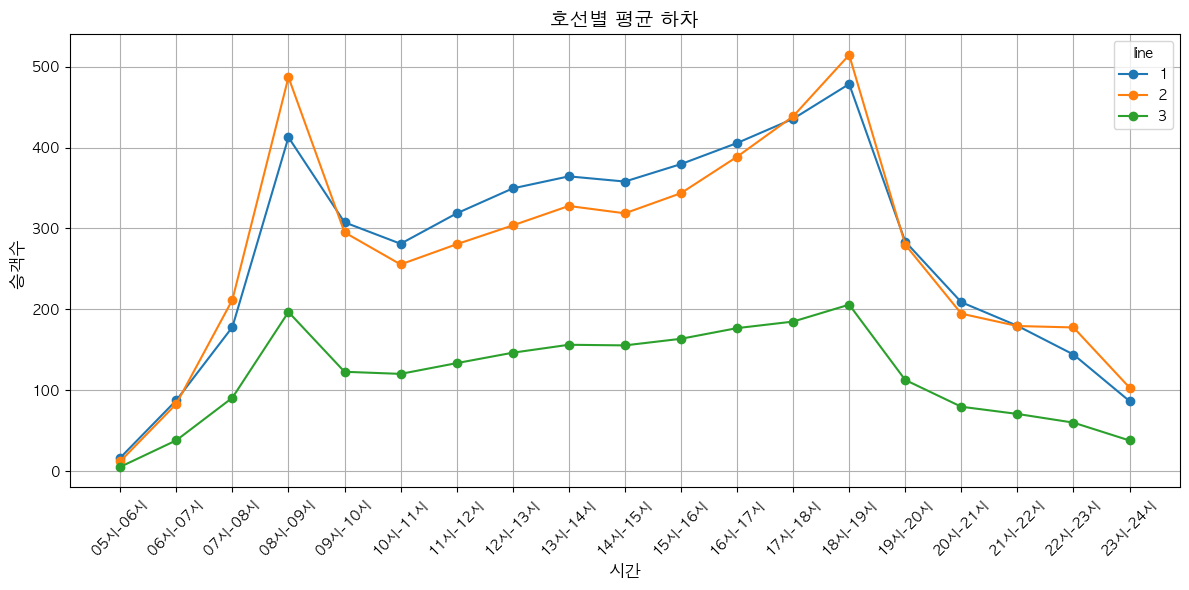

In [330]:
# 호선별 시간대별 평균 하차 인원 계산
line_time_avg_down = final_df[final_df['승하차'] == '하차'].groupby('호선')[times].mean().T

# 시각화
plt.figure(figsize=(12, 6))
for line in line_time_avg_down.columns:
    plt.plot(line_time_avg_down.index, line_time_avg_down[line], marker='o', label=line)

plt.title('호선별 평균 하차', fontsize=14) #호선별 시간대 평균 하차 인원 (혼잡도 비교)
plt.xlabel('시간', fontsize=12)#시간대
plt.ylabel('승객수 ', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='line')#호선
plt.tight_layout()
plt.show()

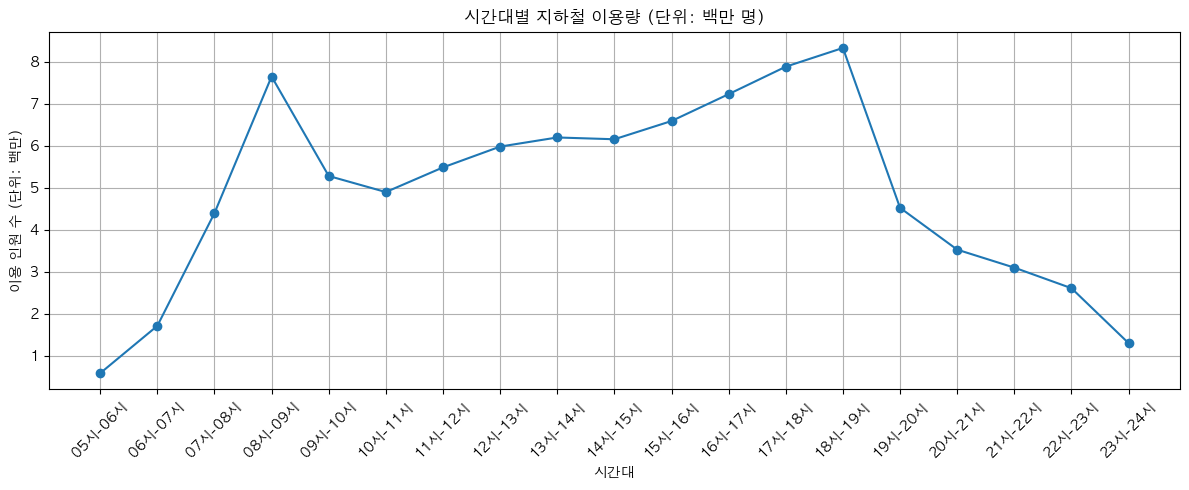

In [331]:
# 시간대별 이용량 총합
time_usage = final_df[times].sum()

# 1,000,000명 단위로 축소
time_usage_millions = time_usage / 1e6

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(times, time_usage_millions, marker='o')
plt.title('시간대별 지하철 이용량 (단위: 백만 명)')
plt.xlabel('시간대')
plt.ylabel('이용 인원 수 (단위: 백만)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

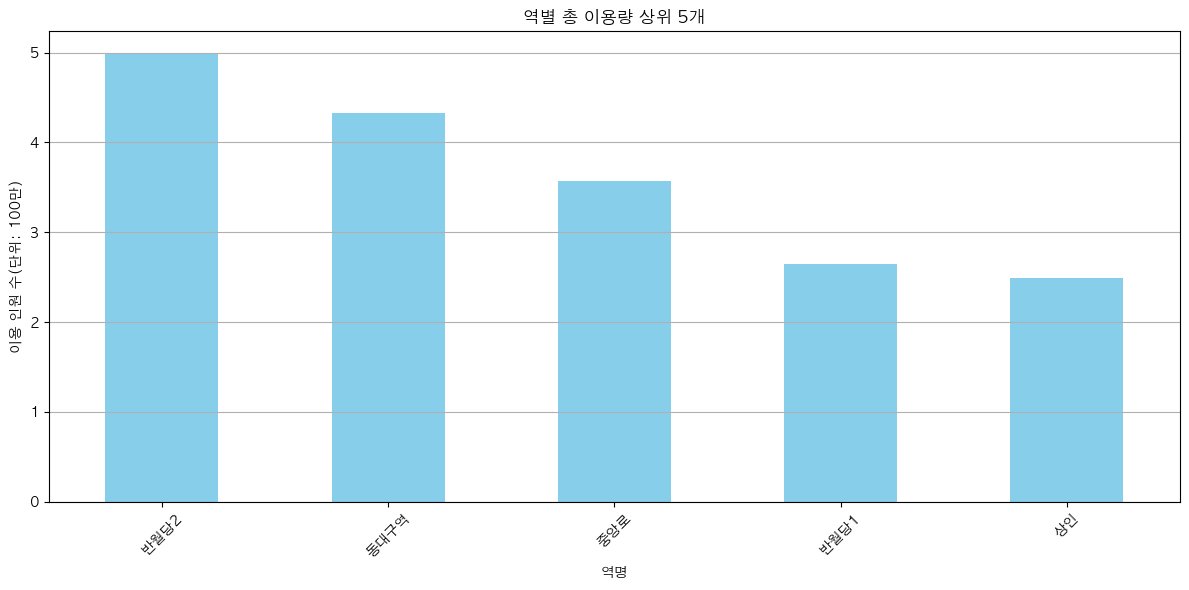

In [332]:
# 각 역별로 일일 총 이용량 계산
station_usage = final_df.groupby('역명')['일계'].sum().sort_values(ascending=False)

#1,000,000 단위로 축소
station_usage_millions = station_usage / 1e6

# 상위 N개만 시각화 (예: 5개)
top_n = 5
plt.figure(figsize=(12, 6))
station_usage_millions.head(top_n).plot(kind='bar', color='skyblue')
plt.title('역별 총 이용량 상위 5개')
plt.ylabel('이용 인원 수(단위: 100만)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

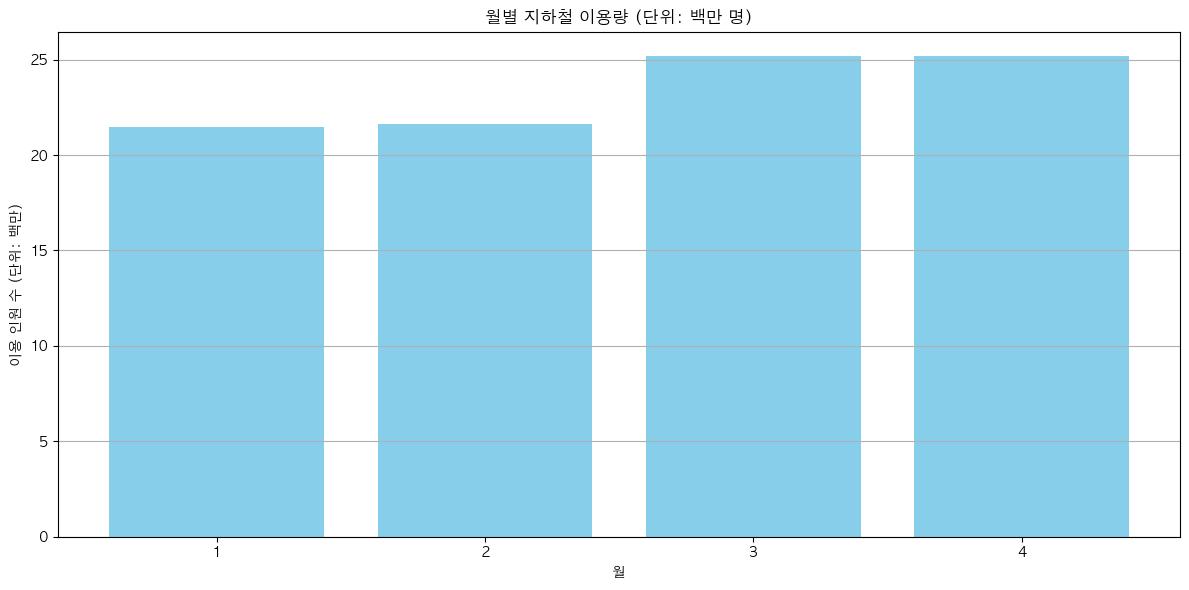

In [333]:
# 월별로 시간대 이용량 합산 (승차 + 하차 포함)
monthly_usage = final_df.groupby('월')[times].sum().sum(axis=1)

# 단위 변경: 백만 명
monthly_usage_millions = monthly_usage / 1e6

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(monthly_usage_millions.index.astype(str), monthly_usage_millions.values, color='skyblue')
plt.title('월별 지하철 이용량 (단위: 백만 명)')
plt.xlabel('월')
plt.ylabel('이용 인원 수 (단위: 백만)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

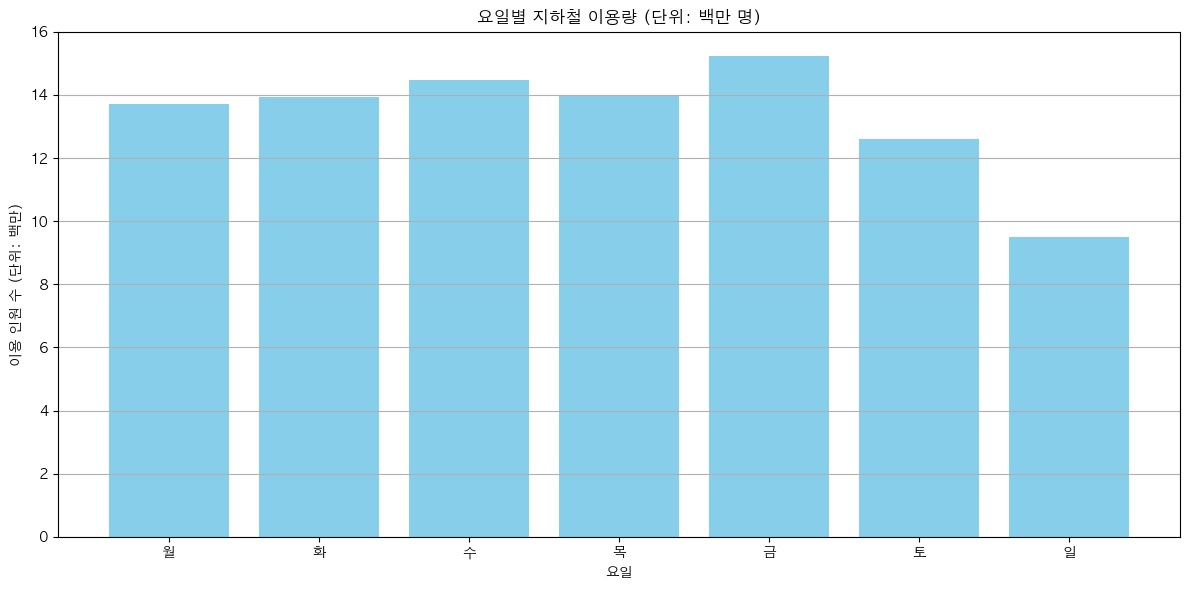

In [334]:
# 요일별로 시간대 이용량 합산 (승차 + 하차 포함)
days_usage = final_df.groupby('요일')[times].sum().sum(axis=1)
order = ['월','화','수','목','금','토','일']
days_usage = days_usage.reindex(order)
# 단위 변경: 백만 명
days_usage_millions = days_usage / 1e6

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(days_usage_millions.index.astype(str), days_usage_millions.values, color='skyblue')
plt.title('요일별 지하철 이용량 (단위: 백만 명)')
plt.xlabel('요일')
plt.ylabel('이용 인원 수 (단위: 백만)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

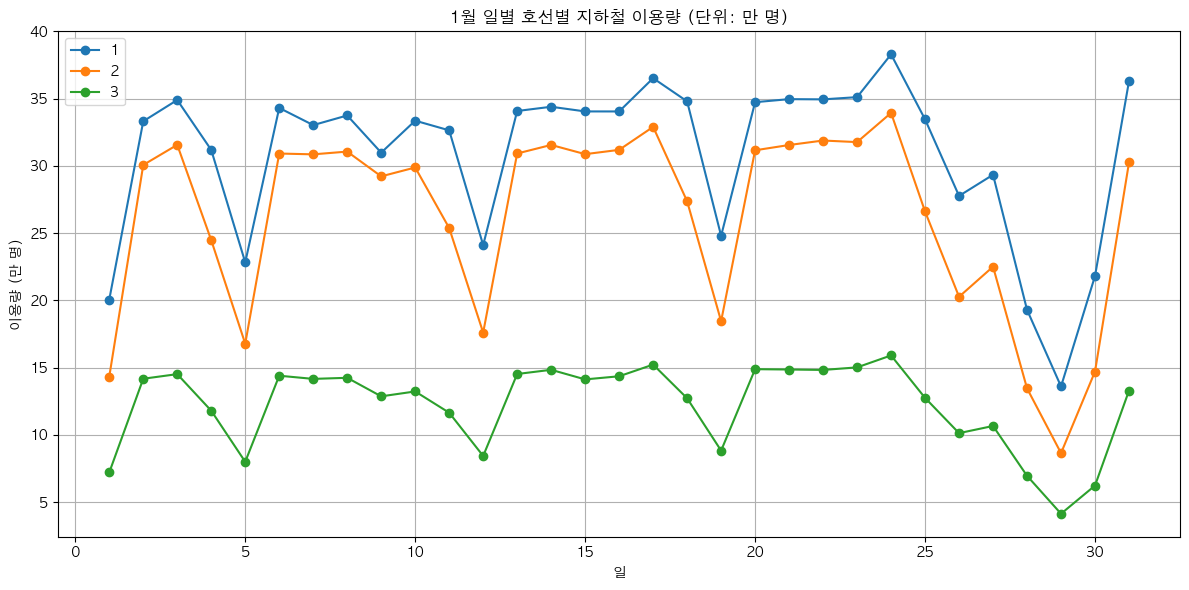

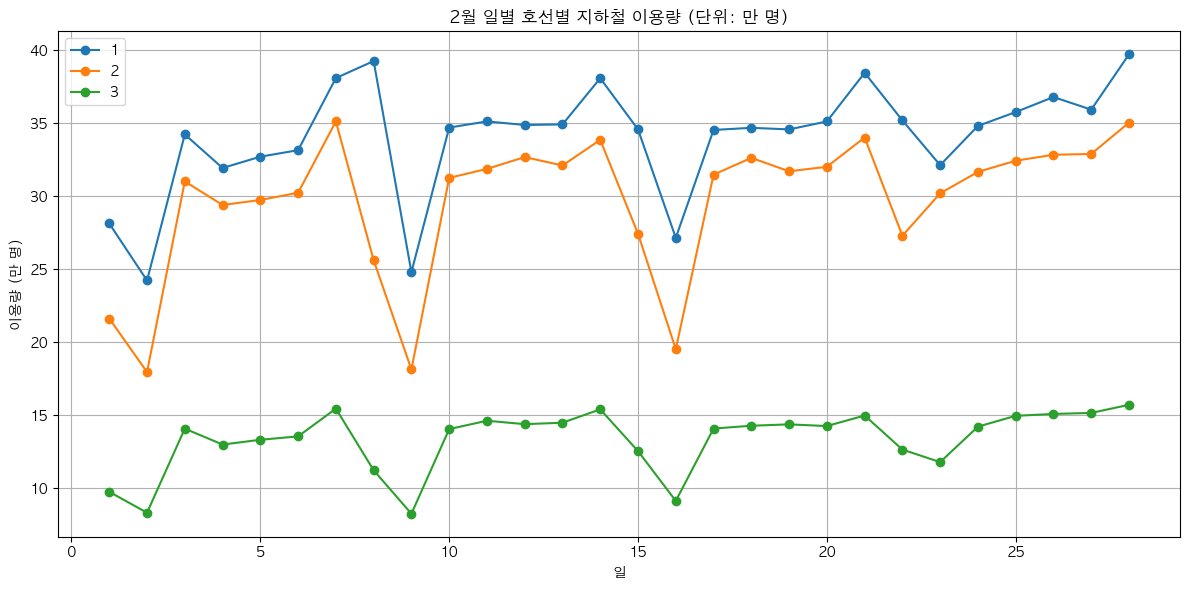

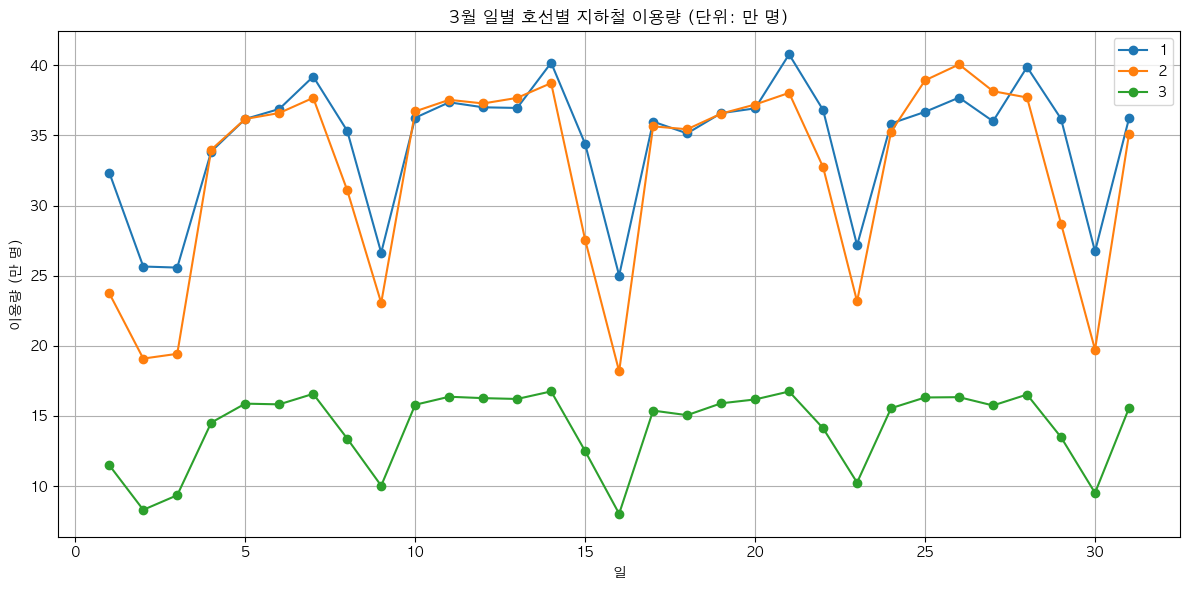

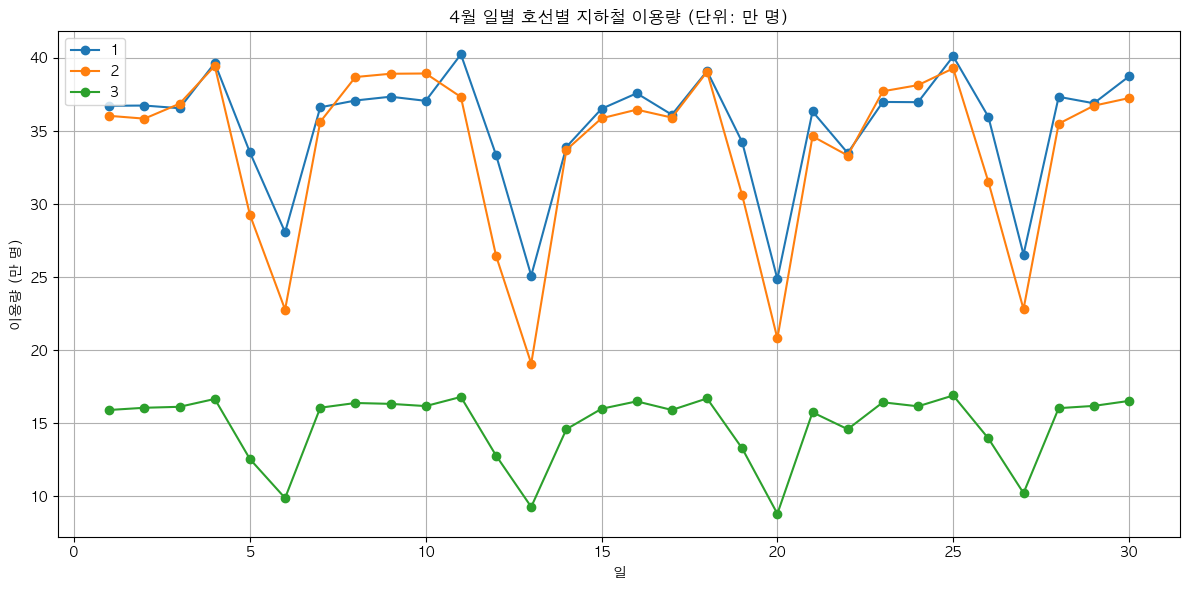

In [338]:
months = [1, 2, 3, 4]
lines = final_df['호선'].unique()

for month in months:
    final_df_month = final_df[final_df['월'] == month]

    # 일별, 호선별 합산 (시간대별 전체 합계)
    daily_line_usage = final_df_month.groupby(['일', final_df['호선']])[times].sum().sum(axis=1).unstack()

    # 단위 조정 (만 명)
    daily_line_usage = daily_line_usage / 1e4

    plt.figure(figsize=(12, 6))
    for line in lines:
        if line in daily_line_usage.columns:
            plt.plot(daily_line_usage.index, daily_line_usage[line], label=f'{line}', marker = 'o')

    plt.title(f'{month}월 일별 호선별 지하철 이용량 (단위: 만 명)')
    plt.xlabel('일')
    plt.ylabel('이용량 (만 명)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [339]:
# 이상치 탐지
Q1 = final_df['일계'].quantile(0.25)
Q3 = final_df['일계'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR # -2045.375
upper_bound = Q3 + 1.5 * IQR # 9139.625

# 이상치 마스크
outliers = final_df[(final_df['일계'] < lower_bound) | (final_df['일계'] > upper_bound)]

print(f"총 이상치 개수: {len(outliers)}")
display(outliers[['월', '일', '역명', '승하차', '일계']])

총 이상치 개수: 1352


,월,일,역명,승하차,일계
32,1,1,중앙로,승차,13089
33,1,1,중앙로,하차,12453
40,1,1,동대구역,승차,12831
41,1,1,동대구역,하차,11660
92,1,1,반월당2,승차,14507
...,...,...,...,...,...
21751,4,30,반월당2,하차,21703
21756,4,30,범어,승차,9510
21757,4,30,범어,하차,9527
21778,4,30,영남대,승차,12476


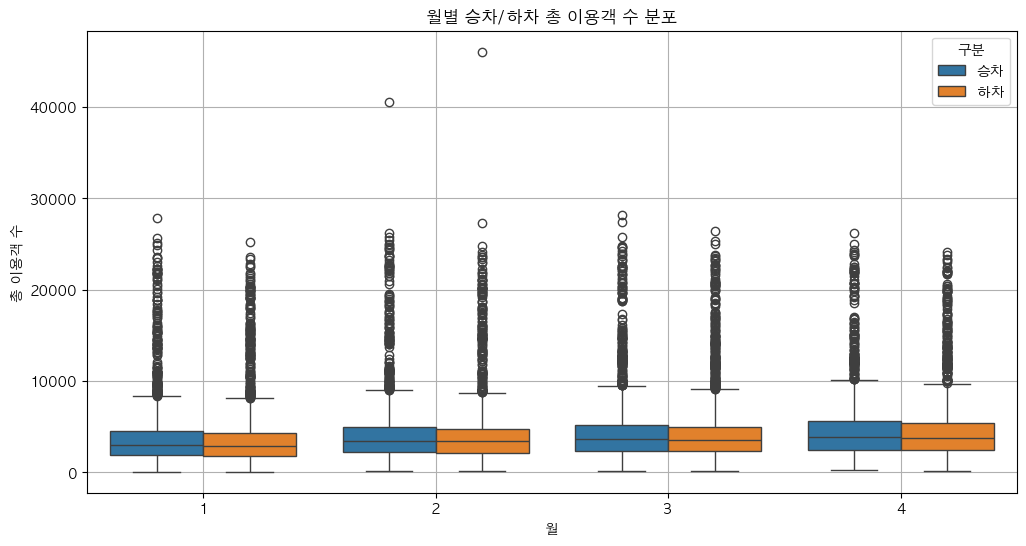

In [340]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df, x='월', y='일계', hue='승하차')
plt.title('월별 승차/하차 총 이용객 수 분포')
plt.xlabel('월')
plt.ylabel('총 이용객 수')
plt.legend(title='구분')
plt.grid(True)
plt.show()

In [341]:
final_df[final_df['월'] == 2]['일계'].max()

final_df[final_df['일계'] >= 40000] #탄핵반대집회일

,월,일,역번호,역명,승하차,05시-06시,06시-07시,07시-08시,08시-09시,09시-10시,10시-11시,11시-12시,12시-13시,13시-14시,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,일계,년,날짜,요일,지점_x,일자,동,PM10등급,PM10수치,PM2.5등급,PM2.5수치,호선,nearest_weather_station,latitude,longitude,지점_y,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),평균 풍속(m/s),최대 순간 풍속 풍향(deg)
6956,2,8,1350,동대구역,승차,85,87,178,511,828,1226,1561,1398,1699,3624,6564,8117,6254,2666,1615,1800,1128,839,411,40591,2025,2025-02-08,토,신암동,2025-02-08,신암동,좋음,18.0,좋음,8.0,1,신암,35.87762,128.6272,860,신암,2025-02-08,-5.3,-9.5,-1.0,0.0,8.7,1.9,301.8
6957,2,8,1350,동대구역,하차,73,593,620,1104,1548,1826,2191,4188,11423,9902,4121,2071,1813,1550,1094,803,673,289,156,46038,2025,2025-02-08,토,신암동,2025-02-08,신암동,좋음,18.0,좋음,8.0,1,신암,35.87762,128.6272,860,신암,2025-02-08,-5.3,-9.5,-1.0,0.0,8.7,1.9,301.8


## 상관관계 분석

=== 일별 변수 상관행렬 ===
일계                  1.000000
최고기온(°C)            0.393403
평균기온(°C)            0.362927
PM10수치              0.318254
최저기온(°C)            0.303227
PM2.5수치             0.154252
평균 풍속(m/s)          0.026686
최대 순간 풍속(m/s)       0.005991
최대 순간 풍속 풍향(deg)   -0.023299
일강수량(mm)           -0.223636
Name: 일계, dtype: float64


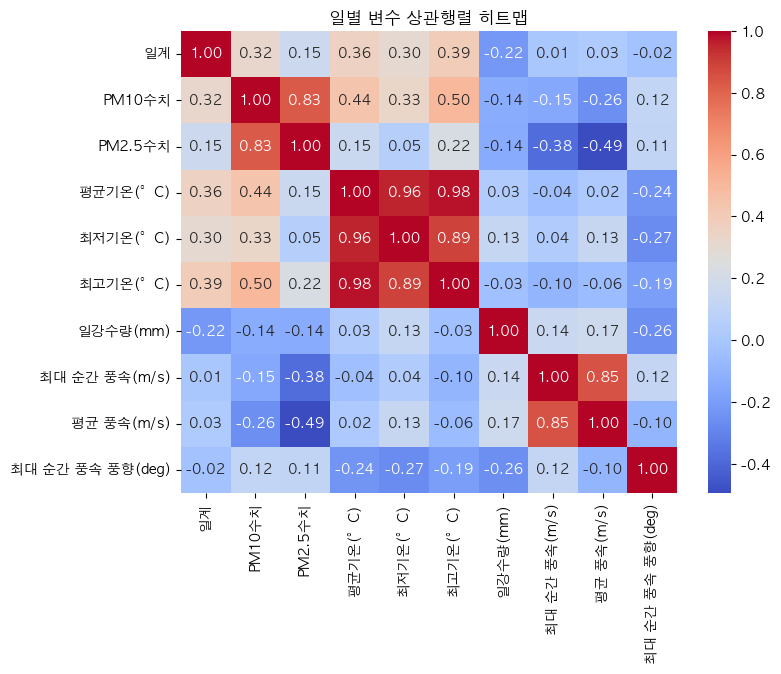

In [343]:
# 필요 컬럼 정의

ride_cols = times  # 승하차 구분 없이 모두 합산
pm_cols = ['PM10수치', 'PM2.5수치']  # 실제 컬럼명 확인
weather_cols = weather.columns[3:].to_list()

# 2. 일별 집계
#   a) 일별 전체 역·시간 승·하차 합계
daily_rides = (
    final_df.groupby('날짜')[ride_cols]
      .sum()
      .sum(axis=1)
      .rename('일계')
      .to_frame()
)

#   b) 일별 PM, 기상 변수 평균
daily_env = (
    final_df.groupby('날짜')[pm_cols + weather_cols]
      .mean()
)

# 병합
daily = daily_rides.join(daily_env)

# 3. 상관계수 계산
corr_matrix = daily.corr(method='pearson')
print("=== 일별 변수 상관행렬 ===")
print(corr_matrix['일계'].sort_values(ascending=False))

# 4. 시각화
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('일별 변수 상관행렬 히트맵')
plt.show()


## 지도시각화


In [344]:
import folium

# 1) 역별 정보 한 번에 모으기
station_info = (
    final_df
    .groupby(['역번호',
              '역명'])
    .agg({
        'latitude':'first',
        'longitude':'first',
        '일계':'mean'
    })
    .reset_index()
)

# 2) 'line' 컬럼 생성 (역번호 첫 자리 → int)
station_info['line'] = station_info['역번호'].astype(str).str[0].astype(int)

# 3) 호선별 색상 매핑
color_map = {
    1: 'red',
    2: 'green',
    3: 'blue'
}
# 그 외 호선은 회색으로
station_info['color'] = station_info['line'].map(color_map).fillna('gray')

# 4) 지도 생성
map_osm = folium.Map(
    location=[
        station_info['latitude'].mean(),
        station_info['longitude'].mean()
    ], 
    zoom_start=11
)

# 5) 마커 추가
for _, row in station_info.iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=(row['일계'] + 1) / 1000,
        popup=f"{row['역명']} ({row['line']}호선): {row['일계']:.0f}명",
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.6
    ).add_to(map_osm)

map_osm